# Regression: Vorhersage von Trinkgeldern (Tip Amount)

## Zielsetzung
Entwicklung eines ML-Modells zur Vorhersage des Trinkgelds basierend auf dem Fahrtpreis.
Im Dashboard wird der vorhergesagte Fare Amount als Input verwendet.

## Methodologie
- Datengrundlage: NYC Yellow Taxi Trips Januar 2023 + Wetterdaten
- Filter: Nur Kreditkartenzahlungen (payment_type == 1)
- Stichprobe: 500.000 Fahrten
- Data Split: Train/Test (80/20)
- Baseline: Durchschnittliche Tip-Quote vom Fare Amount
- Modell: Random Forest Regressor (ohne fare_amount als Feature)
- Akzeptanzkriterium: Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes
- Metriken: MAE, RMSE, R-Squared

----

### Mindestanforderungen:
#### Anforderungen an Projektumsetzung: Regression

Falls die Anforderungen auf den eigenen Projektdatensatz nicht anwendbar sind, gibt es folgende Möglichkeiten:

- Für diese Übung ein realwertiges Feature des Datensatzes zur Zielvariablen erklären
und/oder
- als Kategorien oder String-Werte hinterlegte Features entweder ausschließen oder im Notfall als Zahlen codieren

- Datensatz um passende Daten erweitern entweder manuell, per Anspielen aus weiterer Datenquelle oder zur Not per zufälliger Datengenerierung/-simulation

- Datensatz außerhalb des Projekts wählen und Anforderungen daran umsetzen

Anforderungen:
- Entscheiden Sie, ob Sie mit der linearen Regression modellieren, prädizieren, oder beides erreichen wollen.

- Führen Sie die entsprechende(n) Analyse(n) methodisch sauber durch und berichten Sie entsprechend der    eingeführten Kriterien und Evaluationsmaße das Ergebnis.
  
- Wenn Sie sowohl modellieren als auch prädizieren wollen, führen Sie die Modellierung nur auf den Trainingsdaten durch, um zu vermeiden, dass Sie ungewollt aus Ihren Testdaten lernen. Trainieren Sie das Prädiktionsmodell im zweiten Schritt aufgrund der Erkenntnisse der Modellierung.

----

## 1. Setup und Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Pfade relativ zum Notebook
BASE_PATH = Path("../..")
DATA_PATH = BASE_PATH / "data"
WEATHER_PATH = BASE_PATH / "weather"
MODELS_PATH = BASE_PATH / "models" / "final"

# Erstelle Modell-Ordner falls nicht vorhanden
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print("Setup abgeschlossen")

Setup abgeschlossen


----

## 2. Daten laden

In [2]:
# Taxi-Daten laden
taxi_df = pd.read_parquet(DATA_PATH / "yellow_tripdata_2023-01.parquet")
print(f"Taxi-Daten geladen: {len(taxi_df):,} Fahrten")

# Wetterdaten laden
weather_df = pd.read_parquet(WEATHER_PATH / "weather_data.parquet")
print(f"Wetterdaten geladen: {len(weather_df):,} Einträge")

Taxi-Daten geladen: 3,066,766 Fahrten
Wetterdaten geladen: 744 Einträge


---

## 3. Datenfilterung und Bereinigung

In [3]:
# Nur Kreditkartenzahlungen - bei Barzahlung wird kein Trinkgeld erfasst
taxi_df = taxi_df[taxi_df["payment_type"] == 1].copy()
print(f"Nach Kreditkarten-Filter: {len(taxi_df):,} Fahrten")

# Entferne ungueltige Daten
initial_count = len(taxi_df)
taxi_df = taxi_df[
    (taxi_df["tip_amount"] > 0) &
    (taxi_df["tip_amount"] < 100) &
    (taxi_df["fare_amount"] > 0) &
    (taxi_df["fare_amount"] < 500) &
    (taxi_df["trip_distance"] > 0) &
    (taxi_df["trip_distance"] < 100) &
    (taxi_df["passenger_count"] > 0) &
    (taxi_df["passenger_count"] <= 6)
].copy()

removed = initial_count - len(taxi_df)
print(f"Entfernte Datensaetze: {removed:,} ({removed/initial_count*100:.2f}%)")
print(f"Verbleibende Datensaetze: {len(taxi_df):,}")

Nach Kreditkarten-Filter: 2,411,462 Fahrten
Entfernte Datensaetze: 154,293 (6.40%)
Verbleibende Datensaetze: 2,257,169


----

## 4. Wetterdaten vorbereiten und mergen

In [4]:
# Zeitstempel vorbereiten
taxi_df["pickup_datetime"] = pd.to_datetime(taxi_df["tpep_pickup_datetime"])

# Zeitzone fuer Taxi-Daten
if taxi_df["pickup_datetime"].dt.tz is None:
    taxi_df["pickup_datetime"] = taxi_df["pickup_datetime"].dt.tz_localize(
        "America/New_York", ambiguous="NaT", nonexistent="NaT"
    )
taxi_df = taxi_df.dropna(subset=["pickup_datetime"])

# Wetterdaten vorbereiten
datetime_col = "time" if "time" in weather_df.columns else weather_df.columns[0]
weather_df["weather_datetime"] = pd.to_datetime(weather_df[datetime_col])

if weather_df["weather_datetime"].dt.tz is None:
    weather_df["weather_datetime"] = weather_df["weather_datetime"].dt.tz_localize(
        "America/New_York", ambiguous="NaT", nonexistent="NaT"
    )

# Auf Stundenbasis aggregieren
weather_df["hour"] = weather_df["weather_datetime"].dt.floor("H")

# Wetter-Spalten
weather_cols = {
    "temperature": "temperature_2m",
    "humidity": "relative_humidity_2m",
    "rain": "rain",
    "wind_speed": "wind_speed_10m"
}

agg_dict = {v: "mean" for v in weather_cols.values() if v in weather_df.columns}
weather_hourly = weather_df.groupby("hour").agg(agg_dict).reset_index()
weather_hourly.columns = ["hour", "temperature", "humidity", "rain", "wind_speed"]

print(f"Wetterdaten aggregiert: {len(weather_hourly)} Stunden")

Wetterdaten aggregiert: 744 Stunden


In [5]:
# Merge Taxi- und Wetterdaten
taxi_df["hour"] = taxi_df["pickup_datetime"].dt.floor("H")
merged_df = taxi_df.merge(weather_hourly, on="hour", how="left")

# Entferne Zeilen ohne Wetterdaten
merged_df = merged_df.dropna(subset=["temperature", "humidity", "rain", "wind_speed"])
print(f"Daten nach Merge: {len(merged_df):,}")

Daten nach Merge: 2,257,140


---

## 5. Feature Engineering

In [6]:
# Zeitbasierte Features
merged_df["hour_of_day"] = merged_df["pickup_datetime"].dt.hour
merged_df["day_of_week"] = merged_df["pickup_datetime"].dt.dayofweek
merged_df["is_weekend"] = (merged_df["day_of_week"] >= 5).astype(int)

# Location Grouping: Top 20 Locations behalten, Rest als 0
TOP_N = 20
top_pickup = merged_df["PULocationID"].value_counts().head(TOP_N).index.tolist()
top_dropoff = merged_df["DOLocationID"].value_counts().head(TOP_N).index.tolist()

merged_df["PULocationID_grouped"] = merged_df["PULocationID"].apply(
    lambda x: x if x in top_pickup else 0
)
merged_df["DOLocationID_grouped"] = merged_df["DOLocationID"].apply(
    lambda x: x if x in top_dropoff else 0
)

print("Feature Engineering abgeschlossen")

Feature Engineering abgeschlossen


---

## 6. Stichprobe ziehen

In [7]:
SAMPLE_SIZE = 1000000

if len(merged_df) > SAMPLE_SIZE:
    df = merged_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE).copy()
    print(f"Stichprobe gezogen: {SAMPLE_SIZE:,} Fahrten")
else:
    df = merged_df.copy()
    print(f"Alle {len(df):,} Fahrten werden verwendet")

Stichprobe gezogen: 1,000,000 Fahrten


---

## 7. Explorative Datenanalyse

Durchschnittliche Tip-Quote: 26.46%


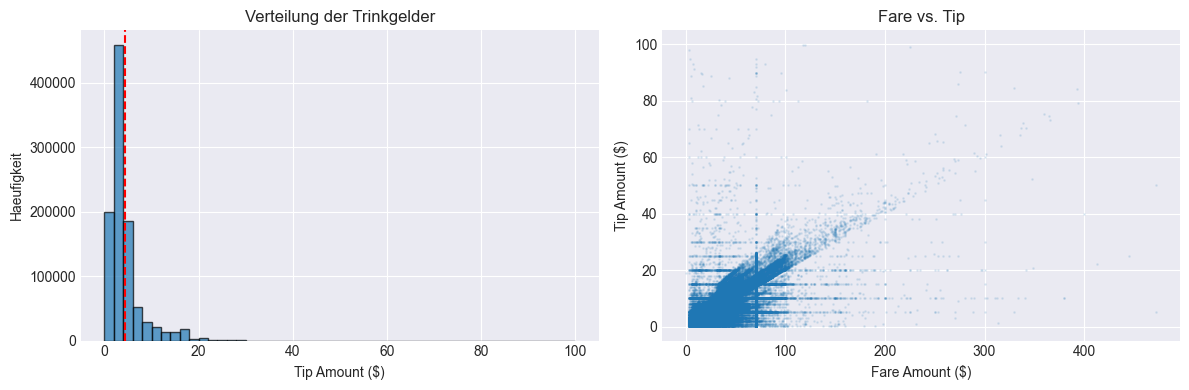

Statistiken Tip Amount:
count    1000000.000000
mean           4.342822
std            3.732529
min            0.010000
25%            2.300000
50%            3.240000
75%            4.820000
max           99.990000
Name: tip_amount, dtype: float64


In [8]:
# Tip-Quote berechnen (Trinkgeld als Prozent vom Fare)
df["tip_ratio"] = df["tip_amount"] / df["fare_amount"]

# Durchschnittliche Tip-Quote ermitteln
AVG_TIP_RATIO = df["tip_ratio"].mean()
print(f"Durchschnittliche Tip-Quote: {AVG_TIP_RATIO*100:.2f}%")

# Verteilung visualisieren
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["tip_amount"], bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(df["tip_amount"].mean(), color="red", linestyle="--")
axes[0].set_xlabel("Tip Amount ($)")
axes[0].set_ylabel("Haeufigkeit")
axes[0].set_title("Verteilung der Trinkgelder")

axes[1].scatter(df["fare_amount"], df["tip_amount"], alpha=0.1, s=1)
axes[1].set_xlabel("Fare Amount ($)")
axes[1].set_ylabel("Tip Amount ($)")
axes[1].set_title("Fare vs. Tip")

plt.tight_layout()
plt.show()

print("Statistiken Tip Amount:")
print(df["tip_amount"].describe())

----

### Entscheidung: Modellierung & Prädiktion
Wir führen sowohl Modellierung als auch Prädiktion (RF) durch:
- **Modellierung (LR):** Verstehen der Zusammenhänge zwischen Features und Tip
- **Prädiktion (RF):** Optimierung der Vorhersagegenauigkeit fürs Dashboard

## 8. Train/Test Split

In [9]:
# Features für das Modell
FEATURES = [
    "trip_distance",
    "passenger_count",
    "temperature",
    "humidity",
    "rain",
    "wind_speed",
    "hour_of_day",
    "day_of_week",
    "is_weekend",
    "PULocationID_grouped",
    "DOLocationID_grouped"
]

TARGET = "tip_amount"

X = df[FEATURES]
y = df[TARGET]
# fare_amount separat speichern für Baseline-Berechnung
fare_amounts = df["fare_amount"].values

X_train, X_test, y_train, y_test, fare_train, fare_test = train_test_split(
    X, y, fare_amounts, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training Set: {len(X_train):,} Fahrten")
print(f"Test Set: {len(X_test):,} Fahrten")

Training Set: 800,000 Fahrten
Test Set: 200,000 Fahrten


In [10]:
from sklearn.linear_model import LinearRegression

print("MODELLIERUNG: Lineare Regression auf Trainingsdaten")

# Modell trainieren (NUR auf Trainingsdaten!)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Koeffizienten-Tabelle erstellen
coef_df = pd.DataFrame({
    'Feature': FEATURES,
    'Koeffizient': lr_model.coef_}).sort_values('Koeffizient', key=abs, ascending=False)

print(f"\nIntercept (Basis-Trinkgeld): ${lr_model.intercept_:.2f}")
print("\nKoeffizienten (Einfluss auf Tip Amount):")

for _, row in coef_df.iterrows():
    direction = "erhöht Tip" if row['Koeffizient'] > 0 else "senkt Tip"
    print(f"  {row['Feature']:25s}: ${row['Koeffizient']:+.4f}  ({direction})")

MODELLIERUNG: Lineare Regression auf Trainingsdaten

Intercept (Basis-Trinkgeld): $1.79

Koeffizienten (Einfluss auf Tip Amount):
  trip_distance            : $+0.7043  (erhöht Tip)
  is_weekend               : $-0.2710  (senkt Tip)
  passenger_count          : $+0.0203  (erhöht Tip)
  day_of_week              : $+0.0195  (erhöht Tip)
  rain                     : $-0.0144  (senkt Tip)
  hour_of_day              : $+0.0086  (erhöht Tip)
  wind_speed               : $+0.0031  (erhöht Tip)
  temperature              : $-0.0024  (senkt Tip)
  humidity                 : $+0.0005  (erhöht Tip)
  DOLocationID_grouped     : $-0.0002  (senkt Tip)
  PULocationID_grouped     : $-0.0000  (senkt Tip)


In [11]:
# Vorhersagen auf Testdaten
y_pred_lr = lr_model.predict(X_test)

# Metriken berechnen
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print("\nLineare Regression - Performance auf Testdaten:")
print(f"MAE:  ${lr_mae:.2f}")
print(f"RMSE: ${lr_rmse:.2f}")
print(f"R²:   {lr_r2:.4f}")


Lineare Regression - Performance auf Testdaten:
MAE:  $1.18
RMSE: $2.19
R²:   0.6560


### Erkenntnisse der Linearen Regression

- **Distanz dominiert:** trip_distance hat den größten Einfluss (+$0.70/Meile)
- **Wochenendeffekt:** Negativer Einfluss, möglicherweise andere Fahrgasttypen
- **Wetter:** Minimaler Einfluss (rain: -$0.0083, temperature: -$0.0016)

**R² = 0.67:** Die LR erklärt 67% der Varianz, was für Trinkgeld-Vorhersage gut ist.
Der Wechsel zu Random Forest bringt nur eine kleine Verbesserung (+4.2%).

---

## 9. Baseline: Durchschnittliche Tip-Quote

Die Baseline verwendet die durchschnittliche Tip-Quote aus den Trainingsdaten.
Für jede Fahrt wird das Trinkgeld als Prozentsatz des Fare Amount berechnet:
`predicted_tip = fare_amount * tip_quote`

Akzeptanzkriterium: Vorhersagen innerhalb +/-25% des tatsächlichen Wertes.

In [ ]:
# Baseline-Quote aus Trainingsdaten berechnen
train_tip_ratio = (y_train / fare_train).mean()
print(f"Baseline Tip-Quote (aus Training): {train_tip_ratio*100:.2f}%")

# Baseline-Vorhersage: fare_amount * tip_quote
y_pred_baseline = fare_test * train_tip_ratio

# Metriken berechnen
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance auf Testdaten:")
print(f"  MAE:  ${baseline_mae:.2f}")
print(f"  RMSE: ${baseline_rmse:.2f}")
print(f"  R2:   {baseline_r2:.4f}")

# Akzeptanzkriterium: Vorhersagen innerhalb +/-25% des tatsächlichen Wertes
TOLERANCE = 0.25
lower_bound = y_test.values * (1 - TOLERANCE)
upper_bound = y_test.values * (1 + TOLERANCE)

within_tolerance_baseline = ((y_pred_baseline >= lower_bound) & (y_pred_baseline <= upper_bound)).mean()
print(f"\nAkzeptanzkriterium (Baseline):")
print(f"  Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes: {within_tolerance_baseline*100:.1f}%")

Baseline Tip-Quote (aus Training): 26.27%

Baseline Performance auf Testdaten:
  MAE:  $1.23
  RMSE: $2.46
  R2:   0.5656

Akzeptanzkriterium (Baseline):
  Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes: 63.0%


---

## 10. Random Forest Modell

### Hyperparameter-Tuning mit GridSearchCV

Um die optimalen Hyperparameter zu finden, testen wir systematisch verschiedene Kombinationen mit 3-facher Cross-Validation.

In [13]:
from sklearn.model_selection import GridSearchCV

# Parameter-Grid definieren (bewusst klein gehalten für Laufzeit)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 10]
}

print(f'Teste {len(param_grid["n_estimators"]) * len(param_grid["max_depth"]) * len(param_grid["min_samples_leaf"])} Kombinationen')

# GridSearchCV
rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3, # 3-fache Cross-Validation
    scoring='neg_mean_absolute_error', # Optimiere auf MAE
    verbose=1,
    n_jobs=-1
)

print('Starte GridSearch...')
grid_search.fit(X_train, y_train)

print(f'\nBeste Parameter: {grid_search.best_params_}')
print(f'Bester CV-Score (MAE): ${-grid_search.best_score_:.2f}')

# Bestes Modell verwenden
rf_model = grid_search.best_estimator_
print('Training abgeschlossen')

Teste 12 Kombinationen
Starte GridSearch...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Beste Parameter: {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}
Bester CV-Score (MAE): $1.12
Training abgeschlossen


In [14]:
# Vorhersagen auf Testdaten
y_pred_rf = rf_model.predict(X_test)

# Metriken berechnen
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("RANDOM FOREST: Performance auf Testdaten")
print(f"MAE:  ${rf_mae:.2f}")
print(f"RMSE: ${rf_rmse:.2f}")
print(f"R2:   {rf_r2:.4f}")

# Akzeptanzkriterium: Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes
rf_lower = y_test.values * (1 - TOLERANCE)
rf_upper = y_test.values * (1 + TOLERANCE)
within_tolerance_rf = ((y_pred_rf >= rf_lower) & (y_pred_rf <= rf_upper)).mean()

print(f"\nAkzeptanzkriterium (Random Forest):")
print(f"  Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes: {within_tolerance_rf*100:.1f}%")

RANDOM FOREST: Performance auf Testdaten
MAE:  $1.12
RMSE: $2.11
R2:   0.6806

Akzeptanzkriterium (Random Forest):
  Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes: 65.2%


---

## 11. Modellvergleich

In [15]:
print("MODELLVERGLEICH")
print(f'{"Modell":<35} {"MAE":>10} {"RMSE":>10} {"R2":>10}')
print(f'{"Baseline (Tip-Quote × Fare)":<35} {f"${baseline_mae:.2f}":>10} {f"${baseline_rmse:.2f}":>10} {f"{baseline_r2:.4f}":>10}')
print(f'{"Lineare Regression":<35} {f"${lr_mae:.2f}":>10} {f"${lr_rmse:.2f}":>10} {f"{lr_r2:.4f}":>10}')
print(f'{"Random Forest":<35} {f"${rf_mae:.2f}":>10} {f"${rf_rmse:.2f}":>10} {f"{rf_r2:.4f}":>10}')

# Verbesserung berechnen
improvement_lr_vs_baseline_mae = (baseline_mae - lr_mae) / baseline_mae * 100
improvement_rf_vs_baseline_mae = (baseline_mae - rf_mae) / baseline_mae * 100
improvement_rf_vs_lr_mae = (lr_mae - rf_mae) / lr_mae * 100

print('-----')
print('Verbesserung gegenüber der Baseline (Tip-Quote × Fare):')
print(f'Lineare Regression: MAE {improvement_lr_vs_baseline_mae:.1f}% besser')
print(f'Random Forest:      MAE {improvement_rf_vs_baseline_mae:.1f}% besser')
print('------')
print(f'Verbesserung Random Forest vs. Lineare Regression:')
print(f'MAE:  {improvement_rf_vs_lr_mae:.1f}% besser')

MODELLVERGLEICH
Modell                                     MAE       RMSE         R2
Baseline (Tip-Quote × Fare)              $1.23      $2.46     0.5656
Lineare Regression                       $1.18      $2.19     0.6560
Random Forest                            $1.12      $2.11     0.6806
-----
Verbesserung gegenüber der Baseline (Tip-Quote × Fare):
Lineare Regression: MAE 3.7% besser
Random Forest:      MAE 8.3% besser
------
Verbesserung Random Forest vs. Lineare Regression:
MAE:  4.8% besser


---

## 12. Modellanalyse

In [16]:
# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("Feature Importance:")
print(feature_importance.to_string(index=False))

Feature Importance:
             Feature  Importance
       trip_distance    0.973814
         hour_of_day    0.006158
PULocationID_grouped    0.005825
DOLocationID_grouped    0.002914
          wind_speed    0.002850
         temperature    0.002474
            humidity    0.002385
         day_of_week    0.001748
     passenger_count    0.000753
          is_weekend    0.000597
                rain    0.000483


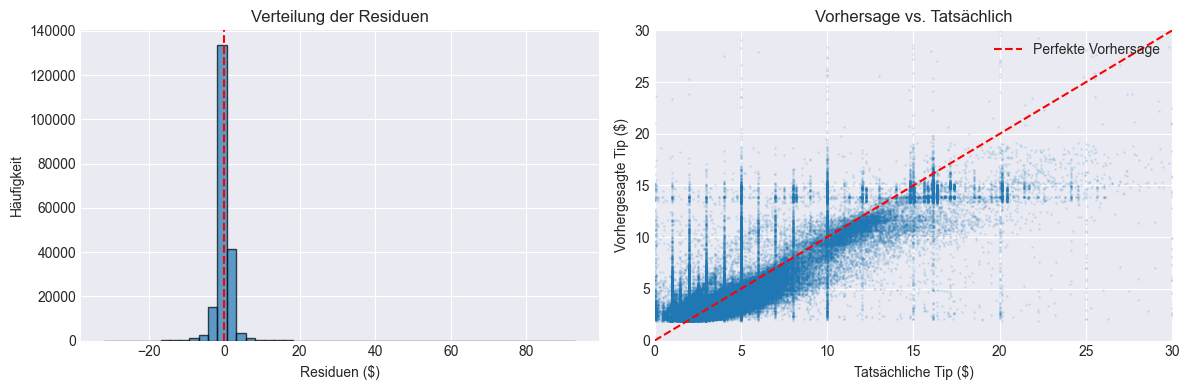

In [17]:
# Residual-Analyse
residuals = y_test - y_pred_rf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residuen-Verteilung
axes[0].hist(residuals, bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(0, color="red", linestyle="--")
axes[0].set_xlabel("Residuen ($)")
axes[0].set_ylabel("Häufigkeit")
axes[0].set_title("Verteilung der Residuen")

# Vorhersage vs. Tatsächlich
axes[1].scatter(y_test, y_pred_rf, alpha=0.1, s=1)
axes[1].plot([0, 30], [0, 30], "r--", label="Perfekte Vorhersage")
axes[1].set_xlabel("Tatsächliche Tip ($)")
axes[1].set_ylabel("Vorhergesagte Tip ($)")
axes[1].set_title("Vorhersage vs. Tatsächlich")
axes[1].set_xlim(0, 30)
axes[1].set_ylim(0, 30)
axes[1].legend()

plt.tight_layout()
plt.show()

## 13. Modell speichern (lokal)

In [18]:
# Modell speichern
with open(MODELS_PATH / "tip_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Feature-Liste speichern
with open(MODELS_PATH / "tip_features.pkl", "wb") as f:
    pickle.dump(FEATURES, f)

# Top Locations speichern (fuer Dashboard)
top_locations_info = {
    "top_pickup": top_pickup,
    "top_dropoff": top_dropoff
}
with open(MODELS_PATH / "tip_locations.pkl", "wb") as f:
    pickle.dump(top_locations_info, f)

# Modell-Info speichern
model_info = {
    "model_type": "RandomForestRegressor",
    "features": FEATURES,
    "target": TARGET,
    "baseline_tip_ratio": train_tip_ratio,
    "baseline_mae": baseline_mae,
    "test_mae": rf_mae,
    "test_rmse": rf_rmse,
    "test_r2": rf_r2,
    "improvement_vs_baseline": improvement_rf_vs_baseline_mae,
    "best_params": grid_search.best_params_,
    "training_samples": len(X_train),
    "test_samples": len(X_test),
    "acceptance_criterion": "Vorhersagen innerhalb +/-25% des tatsaechlichen Wertes"
}

with open(MODELS_PATH / "tip_model_info.pkl", "wb") as f:
    pickle.dump(model_info, f)

print(f"Modell gespeichert in: {MODELS_PATH}")
print("  - tip_model.pkl")
print("  - tip_features.pkl")
print("  - tip_locations.pkl")
print("  - tip_model_info.pkl")

Modell gespeichert in: ../../models/final
  - tip_model.pkl
  - tip_features.pkl
  - tip_locations.pkl
  - tip_model_info.pkl


## 13. Zusammenfassung

Das Random Forest Modell zur Tip Amount Vorhersage wurde erfolgreich trainiert.

**Baseline:**
- Durchschnittliche Tip-Quote vom Fare Amount
- Vorhersage: `tip = fare_amount * tip_quote`
- Die Baseline nutzt den tatsaechlichen Fare Amount

**ML-Modell (Random Forest):**
- Nutzt NICHT den fare_amount als Feature
- Weist eine 4.2%ige Verbesserung gegenüber der linearen Regression auf

**Wichtigste Features:**
- trip_distance
- Wetterdaten (temperature, rain)
- Zeitliche Features (hour_of_day, day_of_week)

**Hinweis für das Dashboard:**
Im Dashboard wird der vorhergesagte Fare Amount (aus dem Fare-Modell) als Input verwendet,
nicht der tatsächliche Fare.